In [1]:
import time,random,json
from common import *
from transformers import AutoTokenizer


def load_dataset(dataset_path: str)-> list:
    with open(dataset_path, 'r') as file:
        prompts = json.load(file)
    return prompts
    
dataset_path = "/home/mcw/common/learning/testing_data/prompts.json"

prompts=load_dataset(dataset_path=dataset_path)

model="TheBloke/Llama-2-7b-Chat-AWQ"

NUM_GPUS=2 # gpus used for inference

def run_vllm(batch_size):
    from vllm import LLM, SamplingParams
    llm = LLM(
        model=model,
        tokenizer=model,
        tensor_parallel_size=2,
        gpu_memory_utilization=0.95,
        max_num_seqs=batch_size,
        quantization="AWQ",
        dtype="float16",
    )

    sampling_params=SamplingParams(
          n=1,
          temperature=0,
          top_p=1.0,
          ignore_eos=False,
          max_tokens=MAX_OUTPUT_TOKENS,
          min_tokens=MIN_OUTPUT_TOKENS
      )
    tokenizer = AutoTokenizer.from_pretrained(model)

    try:
        print("doing warmup")
        for i in range(WARMUP_ITERS):
            outputs=llm.generate(prompts, sampling_params, use_tqdm=True)
        print("warmup done")
        final_output=[]
        start = time.perf_counter()
        for i in range(NUM_ITERS):
            outputs=llm.generate(prompts, sampling_params, use_tqdm=True)
            final_output.append(outputs)   
        end = time.perf_counter()
        total_tokens=0
        for outputs in final_output:
          for output in outputs:
                  generated_text = output.outputs[0].text
                  tokens = len(tokenizer.encode(generated_text))
                  total_tokens+=tokens
        
        average_tokens=total_tokens//NUM_ITERS
        mean_time=(end-start)//NUM_ITERS

        result={
            'num_gpus':NUM_GPUS,
            'num_ques':len(prompts),
            'max_output_tokens':MAX_OUTPUT_TOKENS,
            'min_ouput_tokens':MIN_OUTPUT_TOKENS,
            'batch_size':batch_size,
            'latency':mean_time,
            'tokens_per_sec':average_tokens//(end-start)
        }
        
        return result
    
    except Exception as e:
            print(f"{e}")
            

batch_size=40 # batch size [1,2,4,8,12,16,20,24,36,42]
res=run_vllm(batch_size) 

file_path="./colab_results/result2.json"
with open(file_path, "r") as f:
    data=json.load(f)
data.append(res)
with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)

print("Result updated successfully.")


WARNING 07-10 16:20:37 config.py:244] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 07-10 16:20:37 config.py:698] Defaulting to use mp for distributed inference
WARNING 07-10 16:20:37 config.py:505] Possibly too large swap space. 8.00 GiB out of the 15.56 GiB total CPU memory is allocated for the swap space.
INFO 07-10 16:20:37 llm_engine.py:169] Initializing an LLM engine (v0.5.1) with config: model='TheBloke/Llama-2-7b-Chat-AWQ', speculative_config=None, tokenizer='TheBloke/Llama-2-7b-Chat-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_conf

KeyboardInterrupt: 

(VllmWorkerProcess pid=67493) INFO 07-10 16:20:43 weight_utils.py:261] No model.safetensors.index.json found in remote.
(VllmWorkerProcess pid=67493) INFO 07-10 16:20:51 model_runner.py:255] Loading model weights took 1.8299 GB
(VllmWorkerProcess pid=67493) INFO 07-10 16:31:16 multiproc_worker_utils.py:237] Worker exiting


In [2]:
# %pip install matplotlib

: 

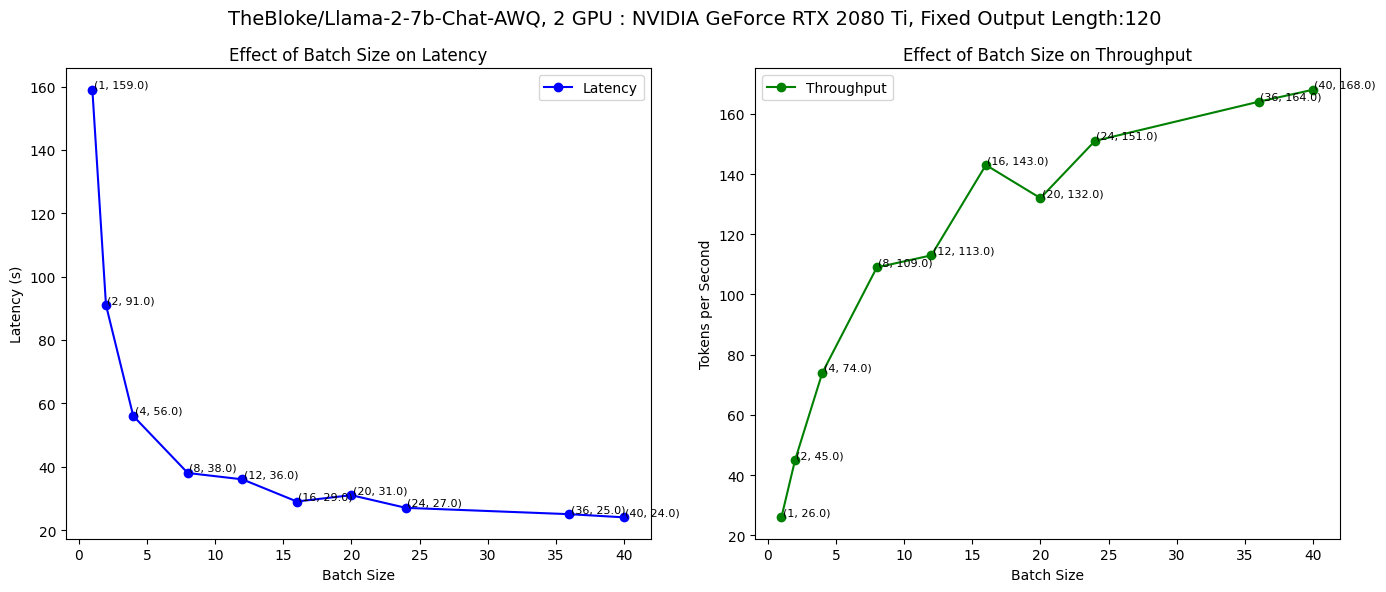

In [3]:
import json
import matplotlib.pyplot as plt

# Load data from JSON file
path="./colab_results/result2.json"

with open(path, 'r') as f:
    data = json.load(f)

# Extracting data for plotting
batch_sizes = [entry['batch_size'] for entry in data]
latencies = [entry['latency'] for entry in data]
tokens_per_sec = [entry['tokens_per_sec'] for entry in data]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Latency vs Batch Size plot
ax1.plot(batch_sizes, latencies, marker='o', linestyle='-', color='b', label='Latency')
for batch_size, latency in zip(batch_sizes, latencies):
    ax1.text(batch_size + 0.1, latency, f'({batch_size}, {latency:.1f})', fontsize=8, verticalalignment='bottom')
ax1.set_title('Effect of Batch Size on Latency')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Latency (s)')
ax1.legend()

# Tokens per Second vs Batch Size plot
ax2.plot(batch_sizes, tokens_per_sec, marker='o', linestyle='-', color='g', label='Throughput')
for batch_size, throughput in zip(batch_sizes, tokens_per_sec):
    ax2.text(batch_size + 0.1, throughput, f'({batch_size}, {throughput:.1f})', fontsize=8, verticalalignment='bottom')
ax2.set_title('Effect of Batch Size on Throughput')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Tokens per Second')
ax2.legend()

# Common title for both plots
fig.suptitle('TheBloke/Llama-2-7b-Chat-AWQ, 2 GPU : NVIDIA GeForce RTX 2080 Ti, Fixed Output Length:120', fontsize=14)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()



In [ ]:
# ..............Benchmark prefix caching...............

In [1]:
import time,random,json
from common import *
from transformers import AutoTokenizer
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


def load_dataset(dataset_path: str)-> list:
    with open(dataset_path, 'r',encoding="utf-8") as file:
        prompts = json.load(file)
    return prompts
    
dataset_path = "./testing_data/similar_prompts.json"

prompts=load_dataset(dataset_path=dataset_path)*200

model="TheBloke/Llama-2-7b-Chat-AWQ"

NUM_GPUS=1 # gpus used for inference

def run_vllm(batch_size,bool_prefix_caching,ques_type):
    from vllm import LLM, SamplingParams
    llm = LLM(
        model=model,
        tokenizer=model,
        tensor_parallel_size=NUM_GPUS,
        gpu_memory_utilization=0.95,
        max_num_seqs=batch_size,
        quantization="AWQ",
        dtype="float16",
        enable_prefix_caching=bool_prefix_caching
    )

    sampling_params=SamplingParams(
          n=1,
          temperature=0,
          top_p=1.0,
          ignore_eos=False,
          max_tokens=MAX_OUTPUT_TOKENS,
          min_tokens=MIN_OUTPUT_TOKENS
      )

    try:
        start = time.perf_counter()
        outputs=llm.generate(prompts, sampling_params, use_tqdm=True)  
        end = time.perf_counter()
        tokenizer = AutoTokenizer.from_pretrained(model)
        total_tokens=0
        for output in outputs:
                generated_text = output.outputs[0].text
                tokens = len(tokenizer.encode(generated_text))
                total_tokens+=tokens
        
        tokens=total_tokens
        mean_time=(end-start)

        result={
            'num_gpus':NUM_GPUS,
            'num_ques':len(prompts),
            'ques_type':ques_type,
            'max_output_tokens':MAX_OUTPUT_TOKENS,
            'min_ouput_tokens':MIN_OUTPUT_TOKENS,
            'batch_size':batch_size,
            'enable_prefix_cache':bool_prefix_caching,
            'latency':mean_time,
            'tokens_per_sec':tokens//(end-start)
        }
        
        return result
    
    except Exception as e:
            print(f"{e}")
            
batch_size=12
enable_prefix_cache=True
ques_type='similar' # ['similar','different']
res=run_vllm(batch_size,enable_prefix_cache,ques_type) 

file_path="./colab_results/result3.json"
with open(file_path, "r",encoding="utf-8") as f:
    data=json.load(f)
data.append(res)
with open(file_path, 'w',encoding="utf-8") as file:
    json.dump(data, file, indent=4)

print("Result updated successfully.")



WARNING 07-11 13:35:23 config.py:244] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 07-11 13:35:23 llm_engine.py:169] Initializing an LLM engine (v0.5.1) with config: model='TheBloke/Llama-2-7b-Chat-AWQ', speculative_config=None, tokenizer='TheBloke/Llama-2-7b-Chat-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=TheBloke/Llama-2-7b-Chat-AWQ, use_v2_block_manager=False, enable_prefix_caching=T

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible

Result updated successfully.


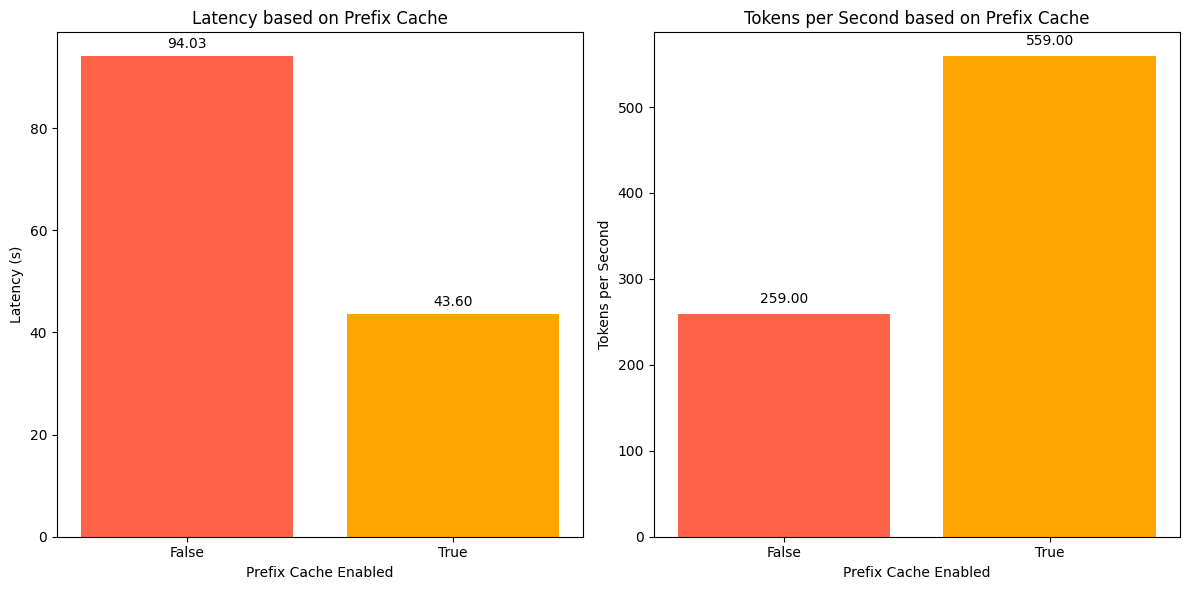

In [4]:
import json
import matplotlib.pyplot as plt

# Read data from JSON file
path="./colab_results/result3.json"
with open(path, 'r',encoding="utf-8") as f:
    data = json.load(f)

# Extracting data
prefix_cache_values = [entry["enable_prefix_cache"] for entry in data]
latency_values = [entry["latency"] for entry in data]
tokens_per_sec_values = [entry["tokens_per_sec"] for entry in data]

# Define warm colors
warm_colors = ['#FF6347', '#FFA500']

# Plotting latency vs prefix_cache
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(['False', 'True'], latency_values, color=warm_colors)
plt.title('Latency based on Prefix Cache')
plt.xlabel('Prefix Cache Enabled')
plt.ylabel('Latency (s)')

# Adding numeric values on top of each bar
for bar, latency in zip(bars, latency_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{latency:.2f}', ha='center', va='bottom')

# Plotting tokens per second vs prefix_cache
plt.subplot(1, 2, 2)
bars = plt.bar(['False', 'True'], tokens_per_sec_values, color=warm_colors)
plt.title('Tokens per Second based on Prefix Cache')
plt.xlabel('Prefix Cache Enabled')
plt.ylabel('Tokens per Second')

# Adding numeric values on top of each bar
for bar, tokens_per_sec in zip(bars, tokens_per_sec_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f'{tokens_per_sec:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# .........vllm throughput visualization................

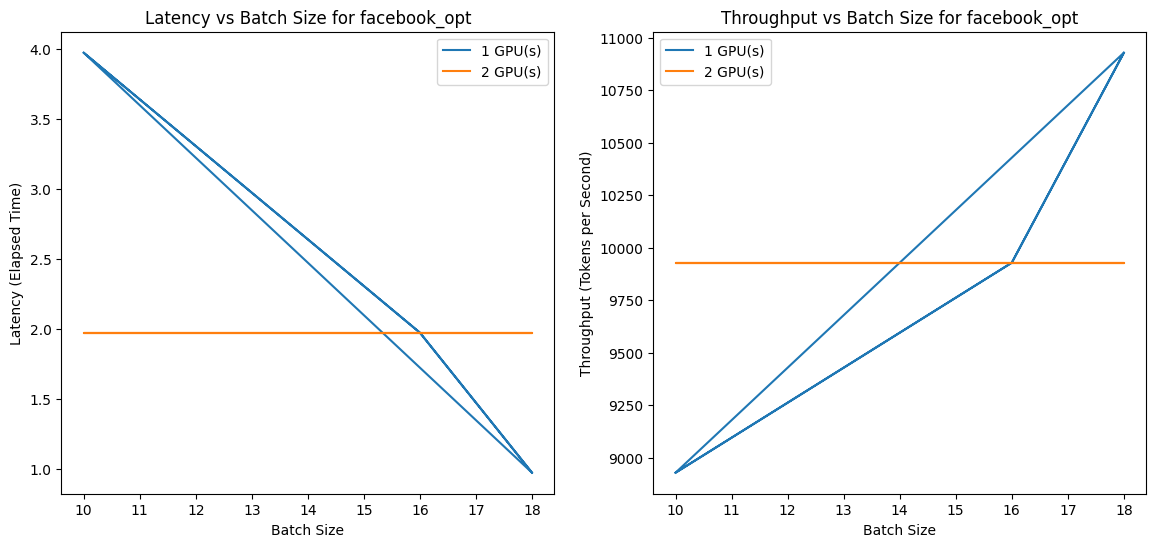

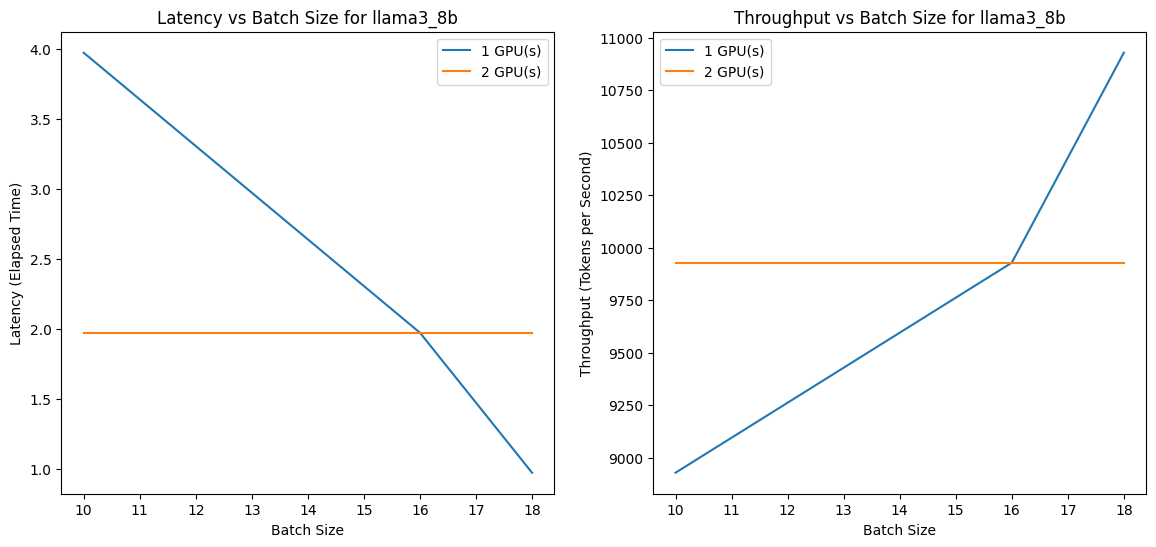

In [3]:
import json
import matplotlib.pyplot as plt
import pandas as pd
path="./testing_data/demo_benchmark.json"
with open(path, 'r',encoding="utf-8") as f:
    data = json.load(f)
    
# Convert JSON data to DataFrame
df = pd.DataFrame(data)

# Function to plot latency and throughput vs batch size for each model
def plot_model_data(model_name, df):
    model_df = df[df['model_name'].str.contains(model_name)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for num_gpus in model_df['num_gpus'].unique():
        gpu_df = model_df[model_df['num_gpus'] == num_gpus]
        ax1.plot(gpu_df['batch_size'], gpu_df['elapsed_time'], label=f'{num_gpus} GPU(s)')
        ax2.plot(gpu_df['batch_size'], gpu_df['tokens_per_second'], label=f'{num_gpus} GPU(s)')
    
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Latency (Elapsed Time)')
    ax1.set_title(f'Latency vs Batch Size for {model_name}')
    ax1.legend()

    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Throughput (Tokens per Second)')
    ax2.set_title(f'Throughput vs Batch Size for {model_name}')
    ax2.legend()

    plt.show()

# Generate plots for each unique model
for model in df['model_name'].apply(lambda x: '_'.join(x.split('_')[:2])).unique():
    plot_model_data(model, df)

In [ ]:
# ..........Rough work ............

In [12]:
PROMPT = ["Discuss the importance of creativity and innovation in leadership, and how collaboration and teamwork contribute to achieving strategic goals.",
    "Explain how effective communication and project management skills lead to success in learning, growth, and overall organizational development.",
    "Describe the role of initiative and problem-solving in critical thinking and adaptability, especially in building resilience and motivation."]

ls=PROMPT*34
len(ls)


102

In [6]:
import json

file_path="./testing_data/similar_prompts.json"
with open(file_path, "r",encoding="utf-8") as f:
    data=json.load(f)
data.append(ls)
with open(file_path, 'w',encoding="utf-8") as file:
    json.dump(data, file, indent=4)

print("Result updated successfully.")

Result updated successfully.


In [4]:
PROMPT = "You are a helpful assistant in recognizes the content of tables in markdown format. Here is a table as fellows. You need to answer my question about the table.\n# Table\n|Opening|Opening|Sl. No.|Film|Cast|Director|Music Director|Notes|\n|----|----|----|----|----|----|----|----|\n|J A N|9|1|Agni Pushpam|Jayabharathi, Kamalahasan|Jeassy|M. K. Arjunan||\n|J A N|16|2|Priyamvada|Mohan Sharma, Lakshmi, KPAC Lalitha|K. S. Sethumadhavan|V. Dakshinamoorthy||\n|J A N|23|3|Yakshagaanam|Madhu, Sheela|Sheela|M. S. Viswanathan||\n|J A N|30|4|Paalkkadal|Sheela, Sharada|T. K. Prasad|A. T. Ummer||\n|F E B|5|5|Amma|Madhu, Srividya|M. Krishnan Nair|M. K. Arjunan||\n|F E B|13|6|Appooppan|Thikkurissi Sukumaran Nair, Kamal Haasan|P. Bhaskaran|M. S. Baburaj||\n|F E B|20|7|Srishti|Chowalloor Krishnankutty, Ravi Alummoodu|K. T. Muhammad|M. S. Baburaj||\n|F E B|20|8|Vanadevatha|Prem Nazir, Madhubala|Yusufali Kechery|G. Devarajan||\n|F E B|27|9|Samasya|Madhu, Kamalahaasan|K. Thankappan|Shyam||\n|F E B|27|10|Yudhabhoomi|K. P. Ummer, Vidhubala|Crossbelt Mani|R. K. Shekhar||\n|M A R|5|11|Seemantha Puthran|Prem Nazir, Jayabharathi|A. B. Raj|M. K. Arjunan||\n|M A R|12|12|Swapnadanam|Rani Chandra, Dr. Mohandas|K. G. George|Bhaskar Chandavarkar||\n|M A R|19|13|Thulavarsham|Prem Nazir, sreedevi, Sudheer|N. Sankaran Nair|V. Dakshinamoorthy||\n|M A R|20|14|Aruthu|Kaviyoor Ponnamma, Kamalahasan|Ravi|G. Devarajan||\n|M A R|26|15|Swimming Pool|Kamal Haasan, M. G. Soman|J. Sasikumar|M. K. Arjunan||\n\n# Question\nWhat' s the content in the (1,1) cells\n"  # noqa: E501

ls=PROMPT
